In [1]:
!wget 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

--2020-04-05 08:57:43--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.2MB/s    in 3.5s    

2020-04-05 08:57:47 (23.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
%%capture
!tar xvzf aclImdb_v1.tar.gz

In [0]:
import os 
from sklearn.datasets import load_svmlight_file
import numpy as np
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
MAX_WORDS = 50000

def make_vocab_dict():
    
    vocab_dict = {}
    vocab_dict_revers = {}
    
    padding = 1

    with open('./aclImdb/imdb.vocab', encoding='utf8') as f:
        for index, word in enumerate(f):
            if (index + padding) >= MAX_WORDS:
              break
            idx = index + padding
            w = word.strip().lower()
            vocab_dict[w] = idx
            vocab_dict_revers[idx] = w
             
    
    return vocab_dict, vocab_dict_revers

In [25]:
imdb_vocab, imdb_vocab_rev  = make_vocab_dict()
len(imdb_vocab.keys())

49999

In [0]:
def rm_tags(text):
    re_tags = re.compile(r'<[^>]+>')
    return re_tags.sub(' ',text)

In [0]:
def dataset_to_df(dataset):
  base_path = 'aclImdb'
  
  texts = []
  ranks = []
  ids = []
  labels = []

  for category in ['pos', 'neg']:
        path = f'./{base_path}/{dataset}/{category}'
        for fname in os.listdir(path):
            if fname.endswith('.txt'):
              id, rank = os.path.splitext(fname)[0].split('_')
              with open(os.path.join(path, fname)) as f:
                content = rm_tags(f.read())
                #content = f.read()
                texts.append(content)
                labels.append(0 if category == 'neg' else 1)
                ids.append(int(id))
                ranks.append(int(rank))
    
  dict = {'label': labels, 'rank': ranks, 'id': ids, 'text': texts}  
  
  #return pd.DataFrame(dict).sample(frac=1)
  return pd.DataFrame(dict)

In [28]:
original_train_df = dataset_to_df('train')
original_train_df.head()

,label,rank,id,text
0,1,10,1926,In 1967 I visited the Lake Elsinore glider-por...
1,1,9,6677,"A film about wannabee's, never-were's and less..."
2,1,10,11812,This movies is the best movie to watch for com...
3,1,7,9567,I watched the DVD of this movie which also com...
4,1,9,4511,I just picked up the DVD release of this movie...


In [29]:
original_test_df = dataset_to_df('test')
original_test_df.head()

,label,rank,id,text
0,1,8,10503,"First, let me review the movie. This movie cre..."
1,1,10,10347,Recovery is an incredibly moving piece of work...
2,1,10,7684,When is ART going to overcome racism? I believ...
3,1,7,9567,Well in to 2002 I've got some catching up to d...
4,1,9,8606,Shohei Imamaura's Black Rain was released in 1...


In [0]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]

    # table = str.maketrans('', '', string.punctuation)
    # text = [w.translate(table) for w in text]

    # text = [word.lower() for word in text if word.isalpha()]
    # text = [word for word in text if len(word) > 1]

    #text = " ".join(text)
    return text

In [0]:
def df_clean_text(df):
  df['text'] = df['text'].apply(clean_text)

  return df

In [0]:
def tokens_to_num(tokens):
  output = []

  for token in tokens:
    if token in imdb_vocab:
      output.append(imdb_vocab[token])
    else:
      output.append(2)

  return output

In [0]:
def df_tokens_to_vec(df):
  df['text'] = df['text'].apply(tokens_to_num)

  return df

In [34]:
train_df = df_clean_text(original_train_df.copy())
train_df.head()

,label,rank,id,text
0,1,10,1926,"[1967, visit, lake, elsinore, gliderport, fly,..."
1,1,9,6677,"[film, wannabee, neverweres, lessthanheroes, m..."
2,1,10,11812,"[movie, best, movie, watch, comic, book, feel,..."
3,1,7,9567,"[watch, dvd, movie, also, come, excellent, com..."
4,1,9,4511,"[pick, dvd, release, movie, holiday, norway, h..."


In [35]:
train_df = df_tokens_to_vec(train_df)
train_df.head()

,label,rank,id,text
0,1,10,1926,"[2, 1945, 2025, 45586, 2, 2271, 4287, 21450, 3..."
1,1,9,6677,"[18, 28859, 2, 2, 95, 3985, 809, 2329, 23917, ..."
2,1,10,11812,"[16, 116, 16, 104, 716, 264, 232, 281, 2255, 1..."
3,1,7,9567,"[104, 279, 16, 80, 211, 310, 1639, 1392, 641, ..."
4,1,9,4511,"[1272, 279, 764, 16, 3134, 13041, 2916, 764, 6..."


In [36]:
test_df = df_clean_text(original_test_df.copy())
test_df.head()

,label,rank,id,text
0,1,8,10503,"[first, let, review, movie, movie, creep, dont..."
1,1,10,10347,"[recovery, incredibly, move, piece, work, hand..."
2,1,10,7684,"[art, go, overcome, racism, believe, american,..."
3,1,7,9567,"[well, 2002, ive, get, catch, look, back, lack..."
4,1,9,8606,"[shohei, imamauras, black, rain, wa, release, ..."


In [37]:
test_df = df_tokens_to_vec(test_df)
test_df.head()

,label,rank,id,text
0,1,8,10503,"[85, 272, 708, 16, 16, 4729, 5300, 54, 256, 14..."
1,1,10,10347,"[15485, 929, 815, 405, 161, 2819, 2, 927, 1281..."
2,1,10,7684,"[512, 138, 2985, 3004, 256, 312, 76, 2223, 228..."
3,1,7,9567,"[72, 2, 18621, 75, 1248, 164, 142, 15053, 318,..."
4,1,9,8606,"[19305, 2, 321, 2411, 27558, 764, 2, 15287, 42..."


In [0]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [0]:
import matplotlib.pyplot as plt

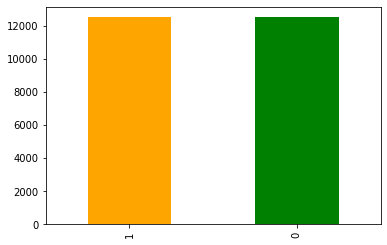

In [42]:
train_df['label'].value_counts().plot.bar(color=['Orange', 'Green'])

Text(0.5, 0, 'Len of review (in words)')

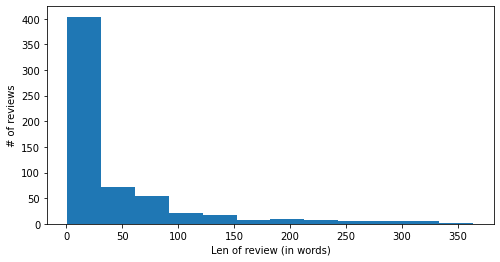

In [190]:
plt.figure(figsize=(8, 4))
train_df['text'].apply(len).value_counts().plot.hist(bins=12)
plt.ylabel('# of reviews')
plt.xlabel('Len of review (in words)')

In [0]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [0]:
def print_loss(history, title=''):
  plot_curves(f'{title} - Loss', 
            [
              history.history['loss'], history.history['val_loss']
            ], 'Loss', 'Epoch',
            [
              'Train', 'Valid'
            ]
            )

In [0]:
def print_acc(history, title=''):
  plot_curves(
      f'{title} - Accuracy', 
      [history.history['accuracy'], history.history['val_accuracy']], 
      'Accuracy', 'Epoch', 
      ['Train', 'Valid']
      )

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
REVIEW_WORD_LEN = 130

In [0]:
def add_start_marker(list):
  if (len(list) < REVIEW_WORD_LEN):
    list.insert(0, 1)

  return list

In [0]:
def df_get_x_y(df):
  #df['text'] = df['text'].apply(add_start_marker)
  return pad_sequences(df['text'].values, maxlen=REVIEW_WORD_LEN), train_df['label'].values

In [54]:
train_x, train_y = df_get_x_y(train_df)

train_x.shape, train_y.shape

((25000, 130), (25000,))

In [55]:
test_x, test_y = df_get_x_y(test_df)

test_x.shape, test_y.shape

((25000, 130), (25000,))

In [0]:
np.savez('train.npz', train_x, train_y)

In [0]:
np.savez('test.npz', test_x, test_y)

In [0]:
from google.colab import files

In [0]:
files.download('./test.npz') 

In [0]:
files.download('./train.npz') 

In [0]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 

In [0]:
from tensorflow.keras.models import Sequential,  load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, Embedding, Bidirectional, Activation, SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import initializers
from tensorflow.keras.layers import InputSpec, Layer, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

**Simple LSTM**

In [88]:
m1 = Sequential()
m1.add(Embedding(MAX_WORDS, 2, input_length=REVIEW_WORD_LEN))
m1.add(Bidirectional(LSTM(64)))
m1.add(Dropout(0.5))
m1.add(Dense(1, activation='sigmoid'))
  
m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

m1_cp = ModelCheckpoint('m1.hdf5', verbose=1, save_best_only=True)
m1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 130, 2)            100000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               34304     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 134,433
Trainable params: 134,433
Non-trainable params: 0
_________________________________________________________________


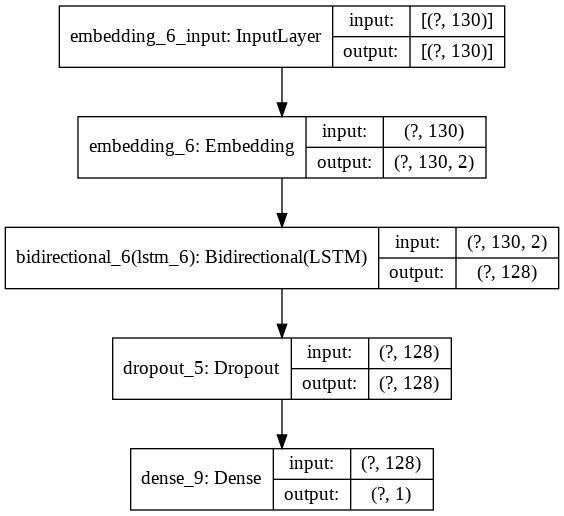

In [89]:
plot_model(m1,  to_file='m1.png', show_shapes=True, show_layer_names=True)
Image('m1.png')

In [90]:
m1_hist = m1.fit(train_x, train_y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[m1_cp])

Epoch 1/5
311/313 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.7282
Epoch 00001: val_loss improved from inf to 0.55937, saving model to m1.hdf5
313/313 [==============================] - 6s 20ms/step - loss: 0.5279 - accuracy: 0.7290 - val_loss: 0.5594 - val_accuracy: 0.7102
Epoch 2/5
310/313 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8986
Epoch 00002: val_loss improved from 0.55937 to 0.51585, saving model to m1.hdf5
313/313 [==============================] - 6s 18ms/step - loss: 0.2609 - accuracy: 0.8987 - val_loss: 0.5159 - val_accuracy: 0.7726
Epoch 3/5
310/313 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9354
Epoch 00003: val_loss improved from 0.51585 to 0.48680, saving model to m1.hdf5
313/313 [==============================] - 6s 18ms/step - loss: 0.1888 - accuracy: 0.9354 - val_loss: 0.4868 - val_accuracy: 0.8084
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.1470 - accur

In [91]:
m1 = load_model('m1.hdf5')
m1_loss, m1_acc = m1.evaluate(test_x, test_y)
m1_loss, m1_acc

782/782 [==============================] - 5s 7ms/step - loss: 0.3605 - accuracy: 0.8552


(0.3604758679866791, 0.8551599979400635)

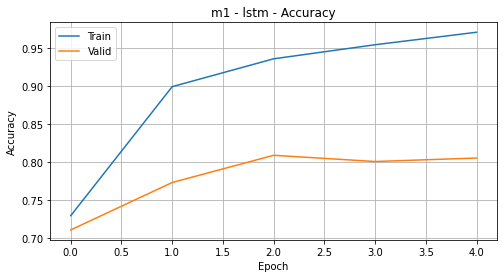

In [92]:
print_acc(m1_hist, 'm1 - lstm')

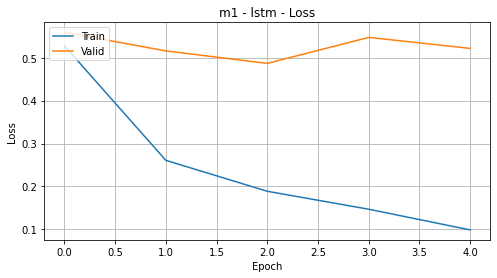

In [93]:
print_loss(m1_hist, 'm1 - lstm')

**Simple GRU**

In [94]:
m2 = Sequential()
m2.add(Embedding(MAX_WORDS, 2, input_length=REVIEW_WORD_LEN))
m2.add(Bidirectional(GRU(64)))
m2.add(Dropout(0.5))
m2.add(Dense(1, activation='sigmoid'))
  
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

m2_cp = ModelCheckpoint('m2.hdf5', verbose=1, save_best_only=True)
m2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 130, 2)            100000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               26112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 126,241
Trainable params: 126,241
Non-trainable params: 0
_________________________________________________________________


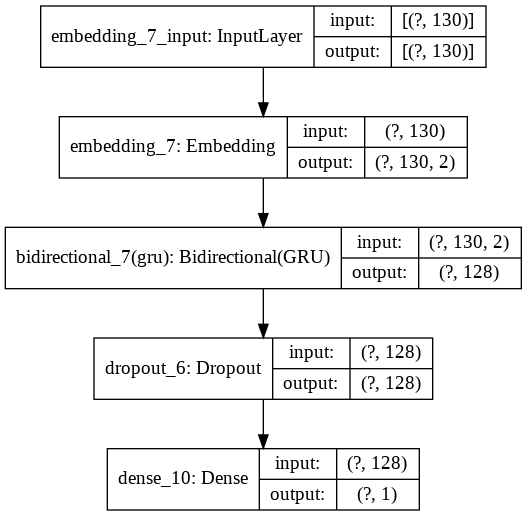

In [95]:
plot_model(m2,  to_file='m2.png', show_shapes=True, show_layer_names=True)
Image('m2.png')

In [96]:
m2_hist = m2.fit(train_x, train_y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[m2_cp])

Epoch 1/5
312/313 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.6533
Epoch 00001: val_loss improved from inf to 0.57401, saving model to m2.hdf5
313/313 [==============================] - 7s 22ms/step - loss: 0.6221 - accuracy: 0.6536 - val_loss: 0.5740 - val_accuracy: 0.7548
Epoch 2/5
312/313 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8670
Epoch 00002: val_loss improved from 0.57401 to 0.41578, saving model to m2.hdf5
313/313 [==============================] - 5s 17ms/step - loss: 0.3224 - accuracy: 0.8672 - val_loss: 0.4158 - val_accuracy: 0.8226
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9244
Epoch 00003: val_loss improved from 0.41578 to 0.35564, saving model to m2.hdf5
313/313 [==============================] - 5s 17ms/step - loss: 0.2042 - accuracy: 0.9244 - val_loss: 0.3556 - val_accuracy: 0.8486
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.1454 - accur

In [97]:
m2 = load_model('m2.hdf5')
m2_loss, m2_acc = m2.evaluate(test_x, test_y)
m2_loss, m2_acc

782/782 [==============================] - 5s 7ms/step - loss: 0.3391 - accuracy: 0.8539


(0.33913764357566833, 0.8539199829101562)

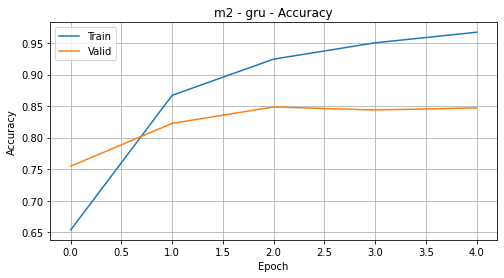

In [98]:
print_acc(m2_hist, 'm2 - gru')

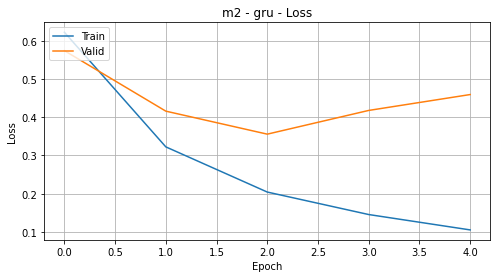

In [99]:
print_loss(m2_hist, 'm2 - gru')

**Glove**

In [100]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-04-05 09:22:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-05 09:22:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-05 09:22:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [101]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
glove_embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [103]:
len(glove_embeddings_index.keys())

400000

In [0]:
glove_embedding_matrix = np.zeros((MAX_WORDS, 100))

for word, i in imdb_vocab.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

In [0]:
m3 = Sequential()
m3.add(Embedding(MAX_WORDS, 100, input_length=REVIEW_WORD_LEN, weights=[glove_embedding_matrix], trainable=False))
m3.add(Bidirectional(LSTM(64)))
m3.add(Dropout(0.5))
m3.add(Dense(1, activation='sigmoid'))
  
m3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

m3_cp = ModelCheckpoint('m3.hdf5', verbose=1, save_best_only=True)

In [192]:
m3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 130, 100)          5000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 5,084,609
Trainable params: 84,609
Non-trainable params: 5,000,000
_________________________________________________________________


In [106]:
m3_hist = m3.fit(train_x, train_y, epochs=8, batch_size=64, validation_split=0.2, callbacks=[m3_cp])

Epoch 1/8
313/313 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.7212
Epoch 00001: val_loss improved from inf to 0.66660, saving model to m3.hdf5
313/313 [==============================] - 6s 20ms/step - loss: 0.5471 - accuracy: 0.7212 - val_loss: 0.6666 - val_accuracy: 0.6274
Epoch 2/8
310/313 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8030
Epoch 00002: val_loss improved from 0.66660 to 0.47134, saving model to m3.hdf5
313/313 [==============================] - 5s 18ms/step - loss: 0.4374 - accuracy: 0.8033 - val_loss: 0.4713 - val_accuracy: 0.7840
Epoch 3/8
310/313 [============================>.] - ETA: 0s - loss: 0.3937 - accuracy: 0.8277
Epoch 00003: val_loss did not improve from 0.47134
313/313 [==============================] - 5s 18ms/step - loss: 0.3930 - accuracy: 0.8281 - val_loss: 0.5254 - val_accuracy: 0.7658
Epoch 4/8
313/313 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8440
Epoch 00004: val_

In [107]:
m3 = load_model('m3.hdf5')
m3_loss, m3_acc = m3.evaluate(test_x, test_y)
m3_loss, m3_acc

782/782 [==============================] - 6s 7ms/step - loss: 0.3567 - accuracy: 0.8467


(0.3567250370979309, 0.8467199802398682)

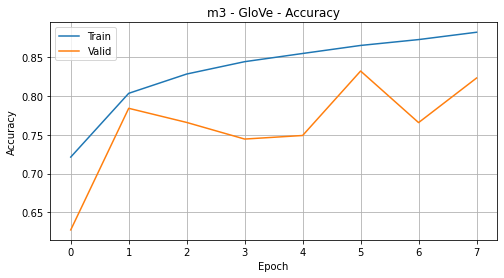

In [108]:
print_acc(m3_hist, 'm3 - GloVe')

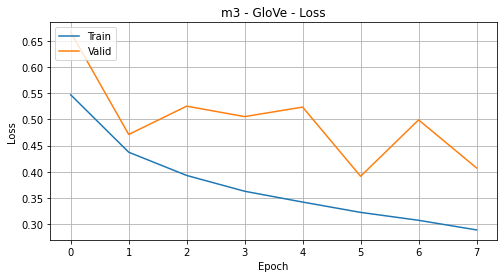

In [109]:
print_loss(m3_hist, 'm3 - GloVe')

**Word 2 Vec**

In [0]:
from gensim.models import Word2Vec, KeyedVectors

In [0]:
w2v_df = df_clean_text(original_train_df.copy())

In [0]:
EMB_VEC_LEN=100

In [0]:
w2v_model = Word2Vec(sentences=w2v_df['text'].values, size=EMB_VEC_LEN, min_count=0, window=5)

In [0]:
word_vectors = w2v_model.wv

In [0]:
w2v_embedding_matrix = np.zeros((MAX_WORDS, EMB_VEC_LEN))

for word, i in imdb_vocab.items():
    if word in word_vectors:
        w2v_embedding_matrix[i] = word_vectors[word]

In [0]:
m4 = Sequential()
m4.add(Embedding(MAX_WORDS, EMB_VEC_LEN, input_length=REVIEW_WORD_LEN, weights=[w2v_embedding_matrix], trainable=False))
m4.add(Bidirectional(LSTM(120)))
m4.add(Dropout(0.5))
m4.add(Dense(1, activation='sigmoid'))
  
m4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

m4_cp = ModelCheckpoint('m4.hdf5', verbose=1, save_best_only=True)
#m3.summary()

In [155]:
m4_hist = m4.fit(train_x, train_y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[m4_cp])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7639
Epoch 00001: val_loss improved from inf to 0.57061, saving model to m4.hdf5
313/313 [==============================] - 7s 23ms/step - loss: 0.4926 - accuracy: 0.7639 - val_loss: 0.5706 - val_accuracy: 0.7132
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8249
Epoch 00002: val_loss did not improve from 0.57061
313/313 [==============================] - 6s 20ms/step - loss: 0.3994 - accuracy: 0.8249 - val_loss: 0.5946 - val_accuracy: 0.7100
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8439
Epoch 00003: val_loss improved from 0.57061 to 0.51042, saving model to m4.hdf5
313/313 [==============================] - 6s 21ms/step - loss: 0.3634 - accuracy: 0.8439 - val_loss: 0.5104 - val_accuracy: 0.7398
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8586
Epoch 00004: val_

In [156]:
m4 = load_model('m4.hdf5')
m4_loss, m4_acc = m4.evaluate(test_x, test_y)
m4_loss, m4_acc

782/782 [==============================] - 6s 8ms/step - loss: 0.3393 - accuracy: 0.8543


(0.3392564654350281, 0.8542799949645996)

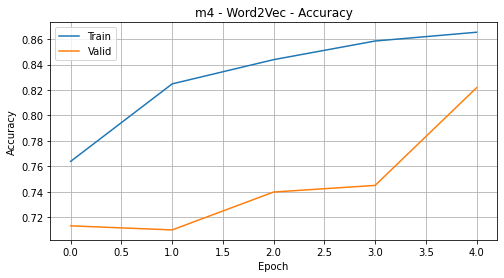

In [157]:
print_acc(m4_hist, 'm4 - Word2Vec')

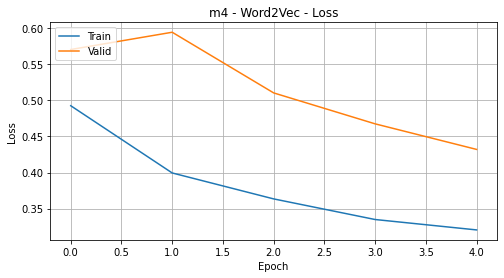

In [158]:
print_loss(m4_hist, 'm4 - Word2Vec')

In [0]:
m5 = Sequential()
m5.add(Embedding(MAX_WORDS, EMB_VEC_LEN, input_length=REVIEW_WORD_LEN, weights=[w2v_embedding_matrix], trainable=False))
m5.add(Bidirectional(LSTM(64, return_sequences=True)))
m5.add(Bidirectional(LSTM(32)))
m5.add(Dropout(0.5))
m5.add(Dense(1, activation='sigmoid'))
  
m5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

m5_cp = ModelCheckpoint('m5.hdf5', verbose=1, save_best_only=True)

In [193]:
m5.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 130, 100)          5000000   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 130, 128)          84480     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 5,125,761
Trainable params: 125,761
Non-trainable params: 5,000,000
_________________________________________________________________


In [166]:
m5_hist = m5.fit(train_x, train_y, epochs=5, batch_size=64, validation_split=0.2, callbacks=[m5_cp])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7555
Epoch 00001: val_loss improved from inf to 0.56758, saving model to m5.hdf5
313/313 [==============================] - 11s 35ms/step - loss: 0.5032 - accuracy: 0.7555 - val_loss: 0.5676 - val_accuracy: 0.6872
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8248
Epoch 00002: val_loss did not improve from 0.56758
313/313 [==============================] - 10s 31ms/step - loss: 0.3959 - accuracy: 0.8248 - val_loss: 0.6539 - val_accuracy: 0.6500
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8482
Epoch 00003: val_loss did not improve from 0.56758
313/313 [==============================] - 10s 30ms/step - loss: 0.3523 - accuracy: 0.8482 - val_loss: 0.6029 - val_accuracy: 0.6794
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8594
Epoch 00004: val_loss improved from 0.56758

In [167]:
m5 = load_model('m5.hdf5')
m5_loss, m5_acc = m5.evaluate(test_x, test_y)
m5_loss, m5_acc

782/782 [==============================] - 9s 12ms/step - loss: 0.3371 - accuracy: 0.8503


(0.3371092677116394, 0.8502799868583679)

In [0]:
labels = [
    'Base - LSTM',
    'Base - GRU',
    'Glove - LSTM',
    'Word2Vec - LSTM',
    'Word2Vec - LSTMx2',
    'DeepMoji - scratch',
    'DeepMoji - pretrained'
]

test_acc = [
    m1_acc,
    m2_acc,
    m3_acc,
    m4_acc,
    m5_acc,
    0.8401600122451782,
    0.5067
]

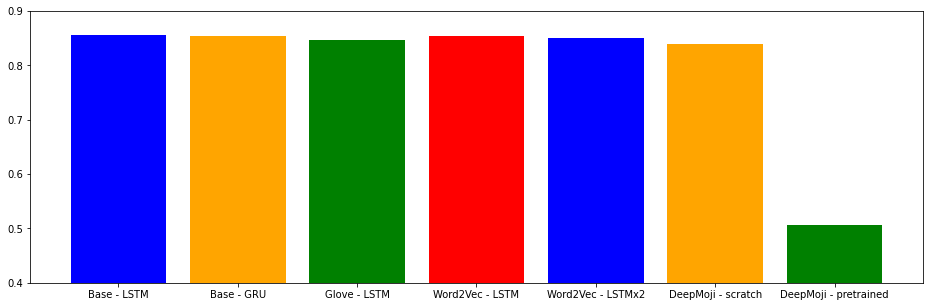

In [202]:
plt.figure(figsize=(16, 5))
#ax = fig.add_axes([0,0,1,1])
plt.bar(labels,test_acc, color=['Blue', 'Orange', 'Green', 'Red'])
plt.ylim(0.4, 0.9)
plt.show()